In [20]:
# allocate pollution site to nearst weather tracking location 
from shapely.geometry import Point
import geopandas
import pandas

monetoring_site_gpd = geopandas.read_file('data/monitoring_station/monitoring_station.shp').drop([10]).to_crs(epsg=4326)

weather_site = pandas.read_csv('data/weather/sites.csv')

weather_site_gpd = geopandas.GeoDataFrame(weather_site, 
                            geometry= geopandas.points_from_xy(y=weather_site['lat'].to_numpy(), 
                                                               x= weather_site['long'].to_numpy(), 
                                                               crs="EPSG:4326"))
weather_site_gpd = weather_site_gpd.to_crs(epsg=25833)
monetoring_site_gpd = monetoring_site_gpd.to_crs(epsg=25833)

def distance(geometry):
    distance = weather_site_gpd.distance(geometry)
    return [weather_site_gpd['index'][distance.argmin()],
            weather_site_gpd['name'][distance.argmin()],
            distance.min()]

monetoring_site_gpd['index_weather'] = monetoring_site_gpd['geometry'].apply(lambda x: distance(x)[0])
monetoring_site_gpd['name'] = monetoring_site_gpd['geometry'].apply(lambda x: distance(x)[1])
monetoring_site_gpd['distance'] = monetoring_site_gpd['geometry'].apply(lambda x: distance(x)[2])
monetoring_site_gpd.to_crs(epsg=4326)
monetoring_site_gpd['id'] = monetoring_site_gpd['id'].apply(lambda x: (x.lower()).replace(' ','')[:5])
monetoring_site_gpd = monetoring_site_gpd[['id', 'stattyp', 'index_weather','name', 'distance', 'geometry']]
monetoring_site_gpd.to_file('data/weather/nearest_monitoring_site/nearest.shp')
monetoring_site_gpd
#monetoring_site_gpd.describe()

C:\Users\richa\AppData\Local\Temp\ipykernel_6560\594732779.py:29: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  monetoring_site_gpd.to_file('data/weather/nearest_monitoring_site/nearest.shp')


,id,stattyp,index_weather,name,distance,geometry
0,mc042,Wohngebiet,433,Berlin-Tempelhof,3121.694839,POINT (393459.020 5816635.250)
1,mc124,Verkehr,433,Berlin-Tempelhof,3419.174948,POINT (390406.146 5810991.699)
2,mc143,Verkehr,433,Berlin-Tempelhof,2689.414876,POINT (394135.247 5814178.610)
3,mc171,Wohngebiet,433,Berlin-Tempelhof,5244.614507,POINT (392699.560 5819341.461)
4,mc174,Verkehr,433,Berlin-Tempelhof,6933.885776,POINT (396182.715 5819313.198)
5,mc190,Verkehr,433,Berlin-Tempelhof,4881.542569,POINT (390219.004 5818973.306)
6,mc221,Verkehr,433,Berlin-Tempelhof,2605.086498,POINT (393366.794 5816009.327)
7,mc145,Stadtrand,400,Berlin-Buch,14104.222234,POINT (384801.959 5835086.639)
8,mc077,Stadtrand,400,Berlin-Buch,1920.336254,POINT (397243.462 5833612.254)
9,mc010,Wohngebiet,433,Berlin-Tempelhof,9103.465144,POINT (388061.816 5822699.437)


In [21]:
import numpy as np 
def preprocess_weather(site_id):
    weather_old =pandas.read_csv(f'data/weather/tageswerte_KL_{site_id}/produkt_klima_tag_{site_id}.txt', sep= ';')
    weather_new = pandas.read_csv(f'data/weather/tageswerte_KL_{site_id}_akt/produkt_klima_tag_{site_id}.txt', sep= ';')
    weather_new = weather_new[(weather_new['MESS_DATUM']>20221231) & (weather_new['MESS_DATUM']<20240101)] # filter
    weather = pandas.concat([weather_old, weather_new], ignore_index=True, sort=False, join= 'outer') # combine
    weather = weather[['STATIONS_ID', 'MESS_DATUM', '  FM',' RSK','RSKF',' SDK','  PM', ' TMK',' UPM']] #select features
    weather.rename(columns={'STATIONS_ID': 'index_weather', 'MESS_DATUM': 'Date', 
                        '  FM': 'windspeed', ' RSK': 'precipitation',
                        'RSKF': 'precip_tpye',' SDK': 'Sunhours',
                        '  PM': 'air_pressure', ' TMK': 'mean_temp',
                        ' UPM': 'humidity'}, inplace=True) # rename features
    weather  = weather[weather['Date']>=20140101] 
    weather = weather.replace(-999.0, np.nan) # insert missing values
    weather = weather.reset_index().drop(['index'], axis=1) # reset and drop index
    weather = weather.astype('float')
    weather.to_csv(f'data/weather/preprocessed/weather_{site_id}.csv') # save locally 
    print(f'Shape of {site_id}: {weather.info()}') # print shape
    print(f'missing values per feature in %: \n {100*weather.isnull().sum()/len(weather)} \n') # print proportion of missing values
    return weather

weather_400 = preprocess_weather('00400')
weather_403 = preprocess_weather('00403')
weather_433 = preprocess_weather('00433')



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3652 entries, 0 to 3651
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index_weather  3652 non-null   float64
 1   Date           3652 non-null   float64
 2   windspeed      0 non-null      float64
 3   precipitation  3651 non-null   float64
 4   precip_tpye    3651 non-null   float64
 5   Sunhours       0 non-null      float64
 6   air_pressure   0 non-null      float64
 7   mean_temp      3652 non-null   float64
 8   humidity       3650 non-null   float64
dtypes: float64(9)
memory usage: 256.9 KB
Shape of 00400: None
missing values per feature in %: 
 index_weather      0.000000
Date               0.000000
windspeed        100.000000
precipitation      0.027382
precip_tpye        0.027382
Sunhours         100.000000
air_pressure     100.000000
mean_temp          0.000000
humidity           0.054765
dtype: float64 

<class 'pandas.core.frame.DataFrame'>
Range

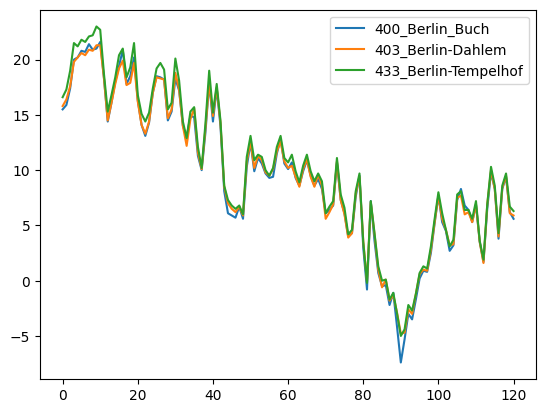

In [22]:
# plot difference with example 
import matplotlib.pyplot as plt

weather_400_sub = weather_400[weather_400['Date']>20230901]
weather_403_sub = weather_403[weather_403['Date']>20230901]
weather_433_sub = weather_433[weather_433['Date']>20230901]

# Assuming df1 and df2 have the same length
x = range(len(weather_400_sub))  # Assuming your x-axis is simply the index

plt.plot(x, weather_400_sub['mean_temp'], label='400_Berlin_Buch')
plt.plot(x, weather_403_sub['mean_temp'], label='403_Berlin-Dahlem')
plt.plot(x, weather_433_sub['mean_temp'], label='433_Berlin-Tempelhof')

plt.legend()
plt.show()


### outlier detection: 

Provided is the weather measurements from three different monitoring sites and the goal is to identify outliers by comparing the different measurements at each concrete timestamp. Therefor theoretically the distance between two measurements is compared to the standard deviation of measurement distances for each individual feature. The standard deviation is calculated with regard to a trimmed mean, which includes the .95th percentile of the data to counteract a distorted mean due to the outlier(s) itself. An outlier detection with regard to the variation within one weather phenomenon is not possible due to the seasonal fluctuation over time. 

The main problem of this approach is the missing data within each dataset, since this does not allow for a comparison in difference. 

First, I calculated the absolute distance between feature for a specific date: weather_diff = abs(weather_400 - weather_403) + abs(weather_400 - weather_433). Here i get a new data frame with the same number of observations but the values are replaced with the absolute difference.

In [23]:
weather_diff = (weather_403 - weather_433).drop(['precipitation', 'windspeed', 'precip_tpye', 'index_weather'], axis= 1) 
weather_diff = weather_diff.dropna() # drop 14.1 % due to either value missing

from scipy.stats import median_abs_deviation
import pandas

outliers = pandas.DataFrame()

def outlier_detect(mad_threshold = 3.5):
    outliers_total = 0 

    for column in weather_diff.columns[1:]:
        data = weather_diff[column]

        # calculate MAD
        mad = median_abs_deviation(data, scale='normal') 
        modified_z_scores = 0.6745 * (data - data.median()) / mad 
        
        # filter data with MAD > threshold
        outliers = abs(data[abs(modified_z_scores) > mad_threshold]) 
        outliers_total += len(outliers) 
        
        # Return statements
        print(f'{len(outliers)} Outliers in {column}:') # print number of outliers per feature
        print(f'min: {round(outliers.min(),2)}, max: {round(outliers.max(), 2)}') # min and max in absolute difference
        print(f'\nabsolute difference between values:\n\n {outliers}') # 

    print(f'With a Threshold of {mad_threshold} Median Absolute Deviation from the trimmed Median there are a total number of {outliers_total} outliers.')

outlier_detect(mad_threshold = 3.5)

print(f'\nDescription of sum of differences between different sites at same day per feature: ')
weather_diff.describe()


17 Outliers in Sunhours:
min: 2.7, max: 4.9

absolute difference between values:

 154     3.400
165     3.800
1111    2.700
1536    4.300
2307    3.200
2465    3.000
2716    3.350
2789    4.900
2979    4.383
3046    2.767
3063    3.033
3086    3.400
3100    2.800
3113    3.567
3115    3.116
3129    3.116
3132    3.550
Name: Sunhours, dtype: float64
9 Outliers in air_pressure:
min: 3.0, max: 4.7

absolute difference between values:

 139    3.1
141    3.1
142    3.0
143    3.1
145    3.1
146    3.1
200    3.1
728    4.7
732    4.7
Name: air_pressure, dtype: float64
0 Outliers in mean_temp:
min: nan, max: nan

absolute difference between values:

 Series([], Name: mean_temp, dtype: float64)
0 Outliers in humidity:
min: nan, max: nan

absolute difference between values:

 Series([], Name: humidity, dtype: float64)
With a Threshold of 3.5 Median Absolute Deviation from the trimmed Median there are a total number of 26 outliers.

Description of sum of differences between different sites at

,Date,Sunhours,air_pressure,mean_temp,humidity
count,3137.0,3137.000000,3137.000000,3137.000000,3137.000000
mean,0.0,0.473836,-3.906248,-0.563946,4.709506
std,0.0,0.644731,0.232875,0.461583,3.211636
min,0.0,-2.700000,-4.700000,-2.400000,-7.000000
25%,0.0,0.000000,-4.010000,-0.900000,2.750000
50%,0.0,0.316000,-3.900000,-0.500000,4.800000
75%,0.0,0.800000,-3.800000,-0.200000,7.000000
max,0.0,4.900000,-3.000000,0.700000,18.000000


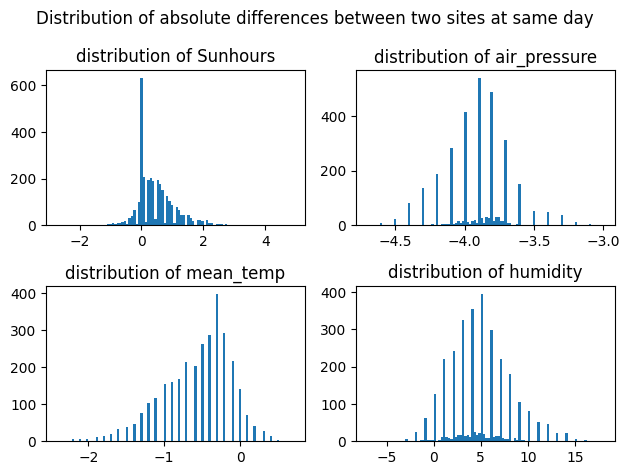

In [58]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots((len(weather_diff.columns[1:])//2), 2)
fig.suptitle('Distribution of absolute differences between two sites at same day')
for n in range(len(weather_diff.columns[1:])):
    
    row = n//2
    column = 0 if (n+1)%2 != 0 else 1
    axs[row, column].hist(weather_diff[weather_diff.columns[1:][n]], bins= 100)
    axs[row, column].set_title(f'distribution of {weather_diff.columns[1:][n]}')
    plt.tight_layout()  


In [70]:
# wind direction for 433 - Berlin_Tempelhof

import pandas 

wind_433 = pandas.read_csv('data/weather/wind_433.csv')
wind_433['date'] = wind_433['SDO_ID'].apply(lambda x: x[:10])

def assign_dirct(degree):
    if degree < 22.5 or degree > 360-22.5:
        return 'N'
    if degree > 22.5 and degree < 45 +22.5:
        return 'NO'
    if degree > 45 +22.5 and degree < 90 +22.5:
        return 'O'
    if degree > 90 +22.5 and degree < 135+22.5:
        return 'SO'
    if degree > 135 +22.5 and degree < 180+22.5:
        return 'S'
    if degree > 180 +22.5 and degree < 225+22.5:
        return 'SW'
    if degree > 225 +22.5 and degree < 270+22.5:
        return 'W'
    if degree > 270 +22.5 and degree < 315+22.5:
        return 'NW'
    else:
        return 'fail'

wind_433['direc'] = wind_433['Zeitstempel'].apply(lambda x: assign_dirct(x))
wind_433

,Produkt_Code,SDO_ID,Zeitstempel,Wert,Qualitaet_Byte,Qualitaet_Niveau,date,direc
OBS_DEU_PT1H_D,433,2002-01-01T00:00:00,210,6,10,NaN,2002-01-01,SW
OBS_DEU_PT1H_D,433,2002-01-01T01:00:00,250,1,10,NaN,2002-01-01,W
OBS_DEU_PT1H_D,433,2002-01-01T02:00:00,280,1,10,NaN,2002-01-01,W
OBS_DEU_PT1H_D,433,2002-01-01T03:00:00,280,1,10,NaN,2002-01-01,W
OBS_DEU_PT1H_D,433,2002-01-01T04:00:00,280,1,10,NaN,2002-01-01,W
...,...,...,...,...,...,...,...,...
OBS_DEU_PT1H_D,433,2023-12-31T19:00:00,160,4,1,NaN,2023-12-31,S
OBS_DEU_PT1H_D,433,2023-12-31T20:00:00,160,4,1,NaN,2023-12-31,S
OBS_DEU_PT1H_D,433,2023-12-31T21:00:00,180,4,1,NaN,2023-12-31,S
OBS_DEU_PT1H_D,433,2023-12-31T22:00:00,190,4,1,NaN,2023-12-31,S


In [72]:
set(wind_433['direc'])

{'N', 'NO', 'NW', 'O', 'S', 'SO', 'SW', 'W'}

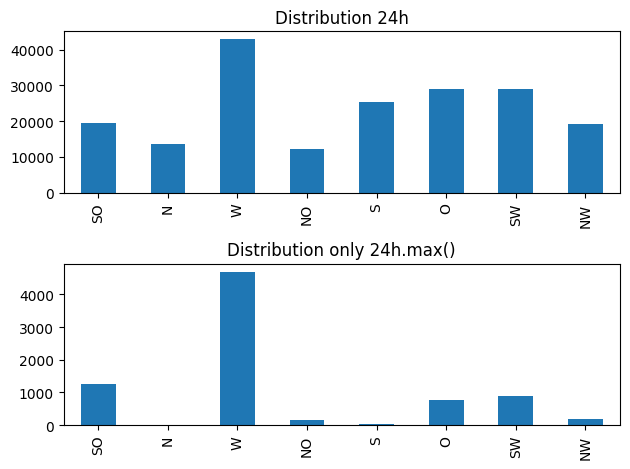

In [74]:
import matplotlib.pyplot as plt

wind_433_daily = wind_433.groupby('date').max() # group by day and take daily modus for wind direction


fig, axs = plt.subplots(2, 1)
#axs[0].hist(wind_433['direc'],orientation='horizontal', range=direc_range)
wind_433['direc'].value_counts().reindex(set(wind_433['direc'])).plot(kind='bar', ax=axs[0])
axs[0].set_title('Distribution 24h')

#axs[1].hist(wind_433_daily['direc'], orientation='horizontal', range=direc_range)
wind_433_daily['direc'].value_counts().reindex(set(wind_433['direc'])).plot(kind='bar', ax=axs[1])
axs[1].set_title('Distribution only 24h.max()')
plt.tight_layout()
